In [1073]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

Feed forward

In [636]:
inputs = np.eye(5)
targets = np.random.rand(len(inputs),8)

weights = []
weights.append(np.random.rand(len(inputs[0]), 7))
weights.append(np.random.rand(len(weights[-1][0]), 9))
weights.append(np.random.rand(len(weights[-1][0]), 6))
weights.append(np.random.rand(len(weights[-1][0]), len(targets[0])))

lr = 0.025

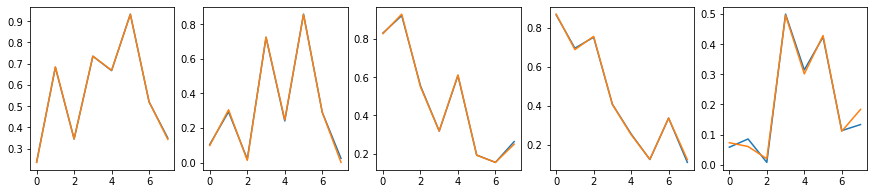

In [653]:
for _ in range(10000):
    g = inputs @ weights[0]
    g2 = g @ weights[1]
    g3 = g2 @ weights[2]
    g4 = g3 @ weights[3]

    u = np.sum([np.outer(inputs[n],(((g4-targets)[n] @ weights[3].T) @ weights[2].T) @ weights[1].T) for n in range(len(inputs))],0)*lr
    u2 = np.sum([np.outer(g[n],((g4-targets)[n] @ weights[3].T) @ weights[2].T) for n in range(len(inputs))],0)*lr
    u3 = np.sum([np.outer(g2[n],(g4-targets)[n] @ weights[3].T) for n in range(len(inputs))],0)*lr
    u4 = np.sum([np.outer(g3[n],(g4-targets)[n]) for n in range(len(inputs))],0)*lr

    weights[0] = weights[0] - u*lr
    weights[1] = weights[1] - u2*lr
    weights[2] = weights[2] - u3*lr
    weights[3] = weights[3] - u4*lr

fig, axs = plt.subplots(1,len(inputs), figsize=(3*len(inputs), 3))
for index,item in enumerate(axs):
    item.plot(np.array([((((inputs @ weights[0]) @ weights[1]) @ weights[2]) @ weights[3])[index],targets[index]]).T)

recurrent

In [1361]:
letters = {chr(i):i/256 for i in range(256)}
text = "Hello there. How are you?"
data = np.array([letters[n] for n in text])

inputs = []
targets = []
for n in range(5,len(data)+1):
    inputs.append(data[n-5:n-1])
    targets.append(data[n-4:n])


wbb = np.random.rand(4, 4)
wab = np.random.rand(4, 4)
wbc = np.random.rand(4, 4)

lr = 0.05

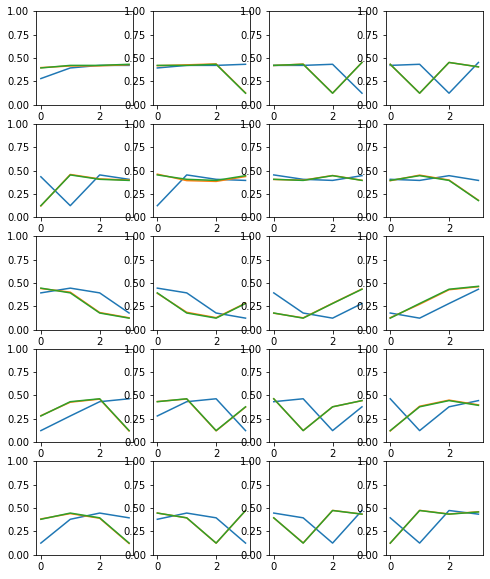

In [1362]:
for _ in range(5):
    for _ in range(100):
        for j in range(len(inputs)-1):
            y = (np.zeros(4) @ wbb) + (inputs[j] @ wab)
            y2 = (y @ wbb) + (inputs[j+1] @ wab)
            g = y2 @ wbc

            uab = np.outer(inputs[j+1],(g-targets[j]) @ wbc.T)
            uab = uab + np.outer(inputs[j],((g-targets[j]) @ wbc.T) @ wbb.T)
            ubb = np.outer(y,(g-targets[j]) @ wbc.T)
            ubc = np.outer(y2,(g-targets[j]))

            wbc = wbc - ubc*lr
            wab = wab - uab*lr
            wbb = wbb - ubb*lr

    y = (np.zeros((len(inputs)-1,4)) @ wbb) + (inputs[:-1] @ wab)
    y2 = (y @ wbb) + (inputs[1:] @ wab)
    g = y2 @ wbc

    fig, axs = plt.subplots(5,(len(inputs)-1)//5, figsize=(2*(len(inputs)-1)/5, 2*5))
    figs = [y for x in axs for y in x]
    for index,item in enumerate(figs):
        item.set_ylim(0,1)
        item.plot(np.array([inputs[index],g[index],targets[index]]).T)
    display(fig)

    clear_output(wait = True)
    plt.pause(0.5)